# Cryto price forecasting using Autoformer 

In [85]:
#Importamos librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
from transformers import AutoModel, AutoTokenizer 
from datetime import datetime
import ta
from sklearn.model_selection import train_test_split
import yfinance as yf

In [86]:
#Descargamos los datos actualizados de BTC
token = "BTC-USD"
token = yf.download(token)
token.to_csv("BTC-USD.csv")

[*********************100%%**********************]  1 of 1 completed


In [87]:
#Obtener el dataset
data = pd.read_csv('BTC-USD.csv', parse_dates=['Date'])
data.set_index('Date', inplace=True)
data.drop(['Adj Close', 'Open', 'High', 'Low'], axis=1, inplace=True)
data


,Close,Volume
Date,,
2014-09-17,457.334015,21056800
2014-09-18,424.440002,34483200
2014-09-19,394.795990,37919700
2014-09-20,408.903992,36863600
2014-09-21,398.821014,26580100
...,...,...
2024-06-21,64096.199219,26188171739
2024-06-22,64252.578125,9858198793
2024-06-23,63180.796875,11170471802


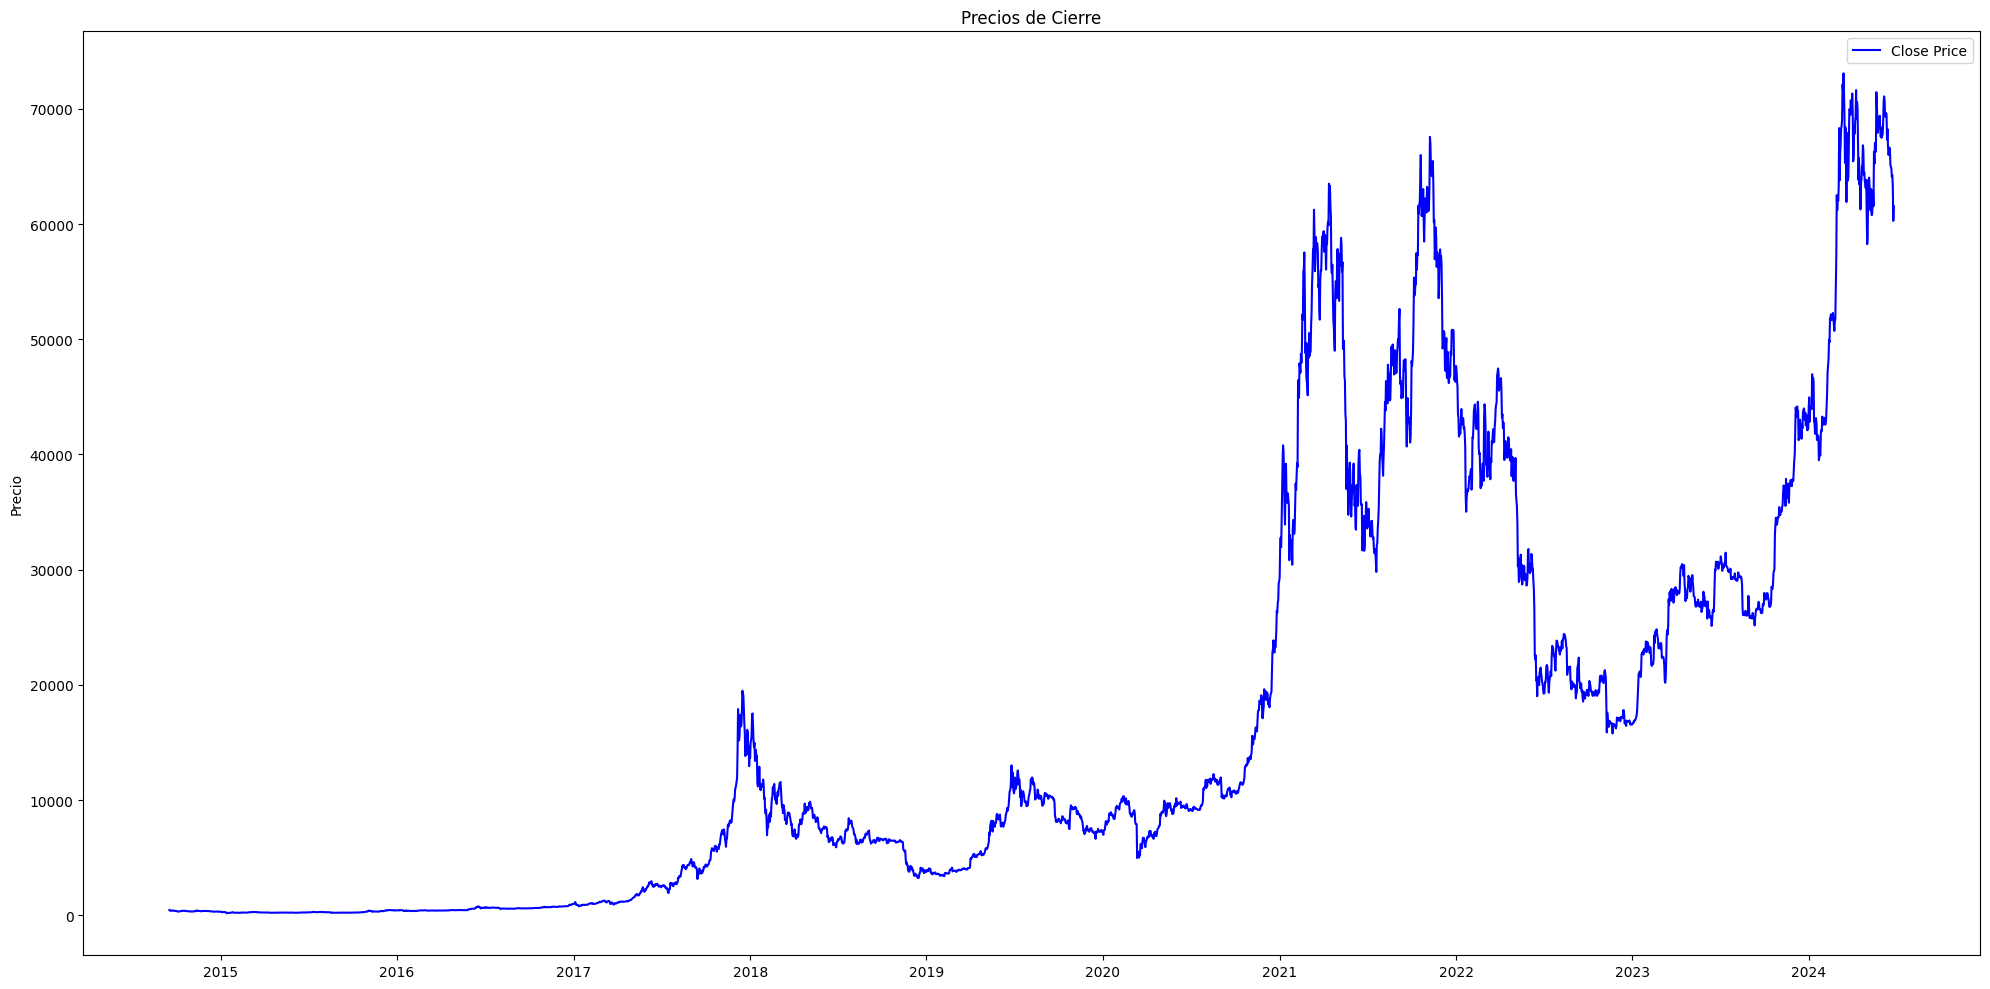

In [88]:
# Visualizacion
plt.figure(figsize=(20, 10))
ax1 = plt.subplot(1, 1, 1)  # Para precios y medias móviles
ax1.plot(data.index, data['Close'], label='Close Price', color='blue')

ax1.set_title('Precios de Cierre')
ax1.set_ylabel('Precio')
ax1.legend()
plt.tight_layout()
plt.show()


## Calculamos Indicadores

In [89]:
# Calcular indicadores
# Añadir medias móviles

data['sma'] = ta.trend.sma_indicator(data['Close'], window=30)
data['ema20'] = ta.trend.ema_indicator(data['Close'], window=20)
data['ema50'] = ta.trend.ema_indicator(data['Close'], window=50)
data['ema200'] = ta.trend.ema_indicator(data['Close'], window=200)


# Añadir RSI
data['rsi'] = ta.momentum.rsi(data['Close'], window=14)

# Añadir MACD
macd = ta.trend.MACD(data['Close'], window_slow=26, window_fast=12, window_sign=9)
data['macd'] = macd.macd()
data['macd_signal'] = macd.macd_signal()

# # Añadir Bandas de Bollinger
# bollinger = ta.volatility.BollingerBands(data['Close'], window=20, window_dev=2)
# data['bollinger_hband'] = bollinger.bollinger_hband()
# data['bollinger_lband'] = bollinger.bollinger_lband()
# data['bollinger_mavg'] = bollinger.bollinger_mavg()

# Ver los datos con indicadores añadidos
print(data[['Close', 'sma', 'ema20', 'ema50', 'ema200', 'rsi', 'macd', 'macd_signal']].head())


                 Close  sma  ema20  ema50  ema200  rsi  macd  macd_signal
Date                                                                     
2014-09-17  457.334015  NaN    NaN    NaN     NaN  NaN   NaN          NaN
2014-09-18  424.440002  NaN    NaN    NaN     NaN  NaN   NaN          NaN
2014-09-19  394.795990  NaN    NaN    NaN     NaN  NaN   NaN          NaN
2014-09-20  408.903992  NaN    NaN    NaN     NaN  NaN   NaN          NaN
2014-09-21  398.821014  NaN    NaN    NaN     NaN  NaN   NaN          NaN


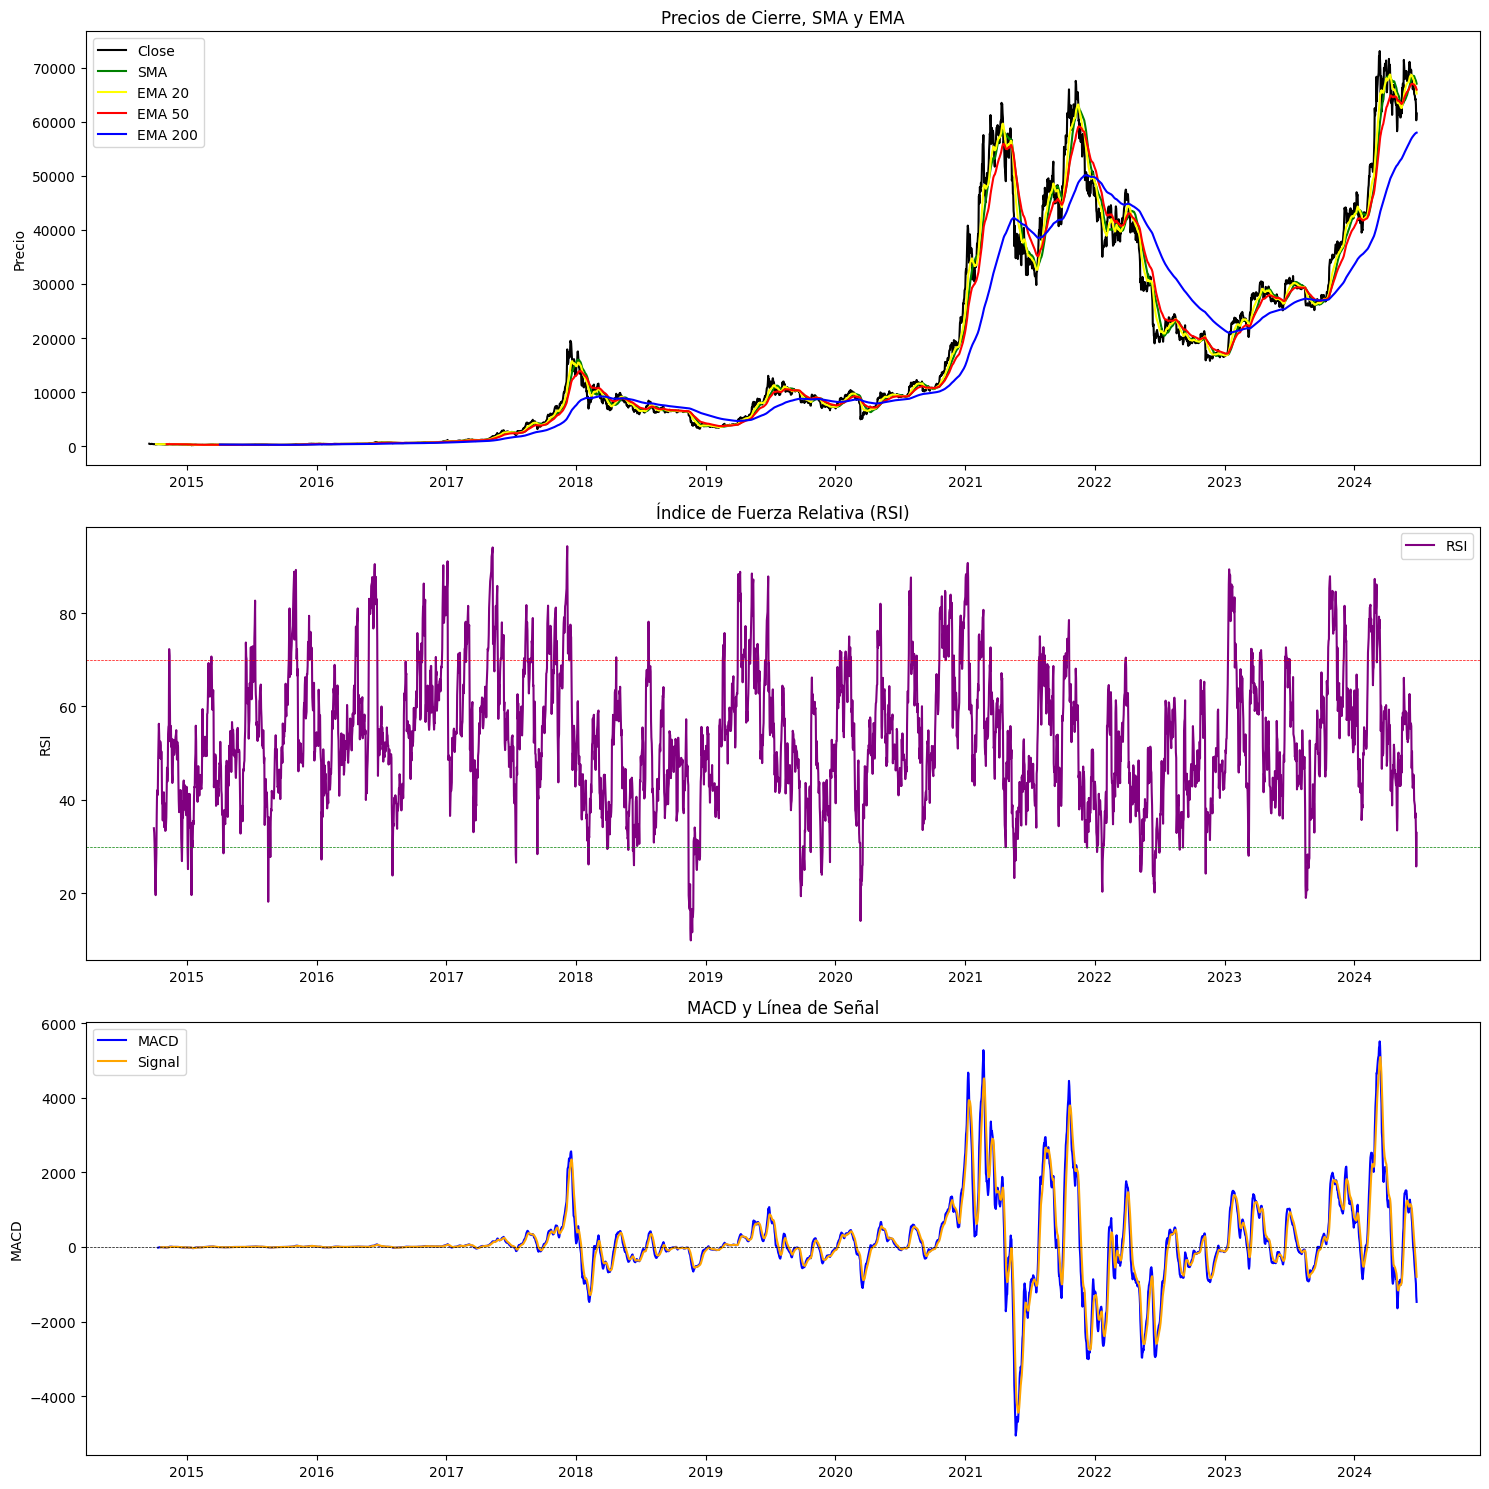

In [90]:
# Configurar el tamaño de la figura
plt.figure(figsize=(15, 15))
# Crear subplots
ax1 = plt.subplot(3, 1, 1)  # Para precios y medias móviles
ax2 = plt.subplot(3, 1, 2, sharex=ax1)  # Para RSI
ax3 = plt.subplot(3, 1, 3, sharex=ax1)  # Para MACD
# Gráfico de precios, SMA y EMA
ax1.plot(data.index, data['Close'], label='Close', color='black')
ax1.plot(data.index, data['sma'], label='SMA', color='green')
ax1.plot(data.index, data['ema20'], label='EMA 20', color='yellow')
ax1.plot(data.index, data['ema50'], label='EMA 50', color='red')
ax1.plot(data.index, data['ema200'], label='EMA 200', color='blue')
ax1.set_title('Precios de Cierre, SMA y EMA')
ax1.set_ylabel('Precio')
ax1.legend()

# Gráfico de RSI
ax2.plot(data.index, data['rsi'], label='RSI', color='purple')
ax2.axhline(70, linestyle='--', color='red', linewidth=0.5)
ax2.axhline(30, linestyle='--', color='green', linewidth=0.5)
ax2.set_title('Índice de Fuerza Relativa (RSI)')
ax2.set_ylabel('RSI')
ax2.legend()

# Gráfico de MACD
ax3.plot(data.index, data['macd'], label='MACD', color='blue')
ax3.plot(data.index, data['macd_signal'], label='Signal', color='orange')
ax3.axhline(0, linestyle='--', color='black', linewidth=0.5)
ax3.set_title('MACD y Línea de Señal')
ax3.set_ylabel('MACD')
ax3.legend()

# Ajustar el layout y mostrar los gráficos
plt.tight_layout()
plt.show()

In [91]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [92]:
data1 = data.dropna()
data1

,Close,Volume,sma,ema20,ema50,ema200,rsi,macd,macd_signal
Date,,,,,,,,,
2015-04-04,253.697006,12493500,266.058734,255.661524,258.734938,307.338692,47.508324,-4.193133,-3.906538
2015-04-05,260.597992,19649200,265.654567,256.131663,258.807999,306.873610,52.432292,-3.252122,-3.775655
2015-04-06,255.492004,20034200,264.962268,256.070744,258.677960,306.362350,48.785829,-2.885117,-3.597547
2015-04-07,253.179993,18467400,264.256468,255.795434,258.462354,305.833173,47.185618,-2.749132,-3.427864
2015-04-08,245.022003,30086400,262.770301,254.769393,257.935281,305.228086,41.956153,-3.262042,-3.394700
...,...,...,...,...,...,...,...,...,...
2024-06-21,64096.199219,26188171739,67884.387760,66718.208053,66593.132430,57812.000134,36.183089,-741.858264,-197.865299
2024-06-22,64252.578125,9858198793,67761.821615,66483.386155,66501.345987,57876.085487,37.161046,-835.984878,-325.489215
2024-06-23,63180.796875,11170471802,67583.644792,66168.853843,66371.128374,57928.868685,33.384915,-985.702128,-457.531798


In [93]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)
    
    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)
        
    df.dropna(inplace=True)
    
    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(data1, lookback)
shifted_df

,Close,Volume,sma,ema20,ema50,ema200,rsi,macd,macd_signal,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,,,,,,,,,
2015-04-11,236.552002,16365200,257.230534,250.558434,255.756771,303.263138,37.268239,-5.308149,-4.024555,236.072006,243.675995,245.022003,253.179993,255.492004,260.597992,253.697006
2015-04-12,236.153000,12387900,255.591068,249.186488,254.987996,302.595375,37.032972,-5.781052,-4.375854,236.552002,236.072006,243.675995,245.022003,253.179993,255.492004,260.597992
2015-04-13,224.587006,31181800,253.681134,246.843680,253.795800,301.819173,30.936420,-7.008323,-4.902348,236.153000,236.552002,236.072006,243.675995,245.022003,253.179993,255.492004
2015-04-14,219.158997,31719000,251.440000,244.207044,252.437494,300.996683,28.560137,-8.322997,-5.586478,224.587006,236.153000,236.552002,236.072006,243.675995,245.022003,253.179993
2015-04-15,223.832993,22562000,249.214667,242.266658,251.315749,300.228885,33.310411,-8.885309,-6.246244,219.158997,224.587006,236.153000,236.552002,236.072006,243.675995,245.022003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-21,64096.199219,26188171739,67884.387760,66718.208053,66593.132430,57812.000134,36.183089,-741.858264,-197.865299,64828.656250,64960.296875,65140.746094,66490.296875,66639.046875,66191.000000,66011.093750
2024-06-22,64252.578125,9858198793,67761.821615,66483.386155,66501.345987,57876.085487,37.161046,-835.984878,-325.489215,64096.199219,64828.656250,64960.296875,65140.746094,66490.296875,66639.046875,66191.000000
2024-06-23,63180.796875,11170471802,67583.644792,66168.853843,66371.128374,57928.868685,33.384915,-985.702128,-457.531798,64252.578125,64096.199219,64828.656250,64960.296875,65140.746094,66490.296875,66639.046875


## Normalizamos el DataSet 

In [94]:
scaler = MinMaxScaler(feature_range=(-1,1))
data_scaled = scaler.fit_transform(shifted_df)
data_scaled

array([[-0.99928487, -0.99996715, -0.99921527, ..., -0.99876506,
        -0.99862492, -0.99881432],
       [-0.99929582, -0.99998982, -0.99926326, ..., -0.99882851,
        -0.99876506, -0.99862492],
       [-0.99961324, -0.99988272, -0.99931917, ..., -0.99905241,
        -0.99882851, -0.99876506],
       ...,
       [ 0.72822026, -0.93640326,  0.9715563 , ...,  0.78201108,
         0.81904951,  0.82313195],
       [ 0.64853691, -0.75414942,  0.96278592, ...,  0.77705865,
         0.78201108,  0.81904951],
       [ 0.68329225, -0.78292999,  0.95598087, ...,  0.77344577,
         0.77705865,  0.78201108]])

## Dividimos en conjunto de Entrenamiento y Test

In [95]:
X = data_scaled[:, 1:]
y = data_scaled[:, 0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.0018, random_state=42, shuffle=False)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3357, 15), (7, 15), (3357,), (7,))

## Convertimos a Tensor

In [96]:
X_train = X_train.reshape((-1, 15, 1))
X_test = X_test.reshape((-1, 15, 1))
y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3357, 15, 1), (7, 15, 1), (3357, 1), (7, 1))

In [97]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([3357, 15, 1]),
 torch.Size([7, 15, 1]),
 torch.Size([3357, 1]),
 torch.Size([7, 1]))

In [98]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [99]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [100]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 15, 1]) torch.Size([16, 1])


In [101]:
import torch
import torch.nn as nn
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [102]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [103]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [104]:
learning_rate = 0.001
num_epochs = 30
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.453
Batch 200, Loss: 0.233

Val Loss: 0.637
***************************************************

Epoch: 2
Batch 100, Loss: 0.119
Batch 200, Loss: 0.036

Val Loss: 0.100
***************************************************

Epoch: 3
Batch 100, Loss: 0.016
Batch 200, Loss: 0.013

Val Loss: 0.057
***************************************************

Epoch: 4
Batch 100, Loss: 0.010
Batch 200, Loss: 0.007

Val Loss: 0.026
***************************************************

Epoch: 5
Batch 100, Loss: 0.006
Batch 200, Loss: 0.005

Val Loss: 0.012
***************************************************

Epoch: 6
Batch 100, Loss: 0.004
Batch 200, Loss: 0.004

Val Loss: 0.006
***************************************************

Epoch: 7
Batch 100, Loss: 0.003
Batch 200, Loss: 0.003

Val Loss: 0.003
***************************************************

Epoch: 8
Batch 100, Loss: 0.003
Batch 200, Loss: 0.003

Val Loss: 0.002
***************************************************



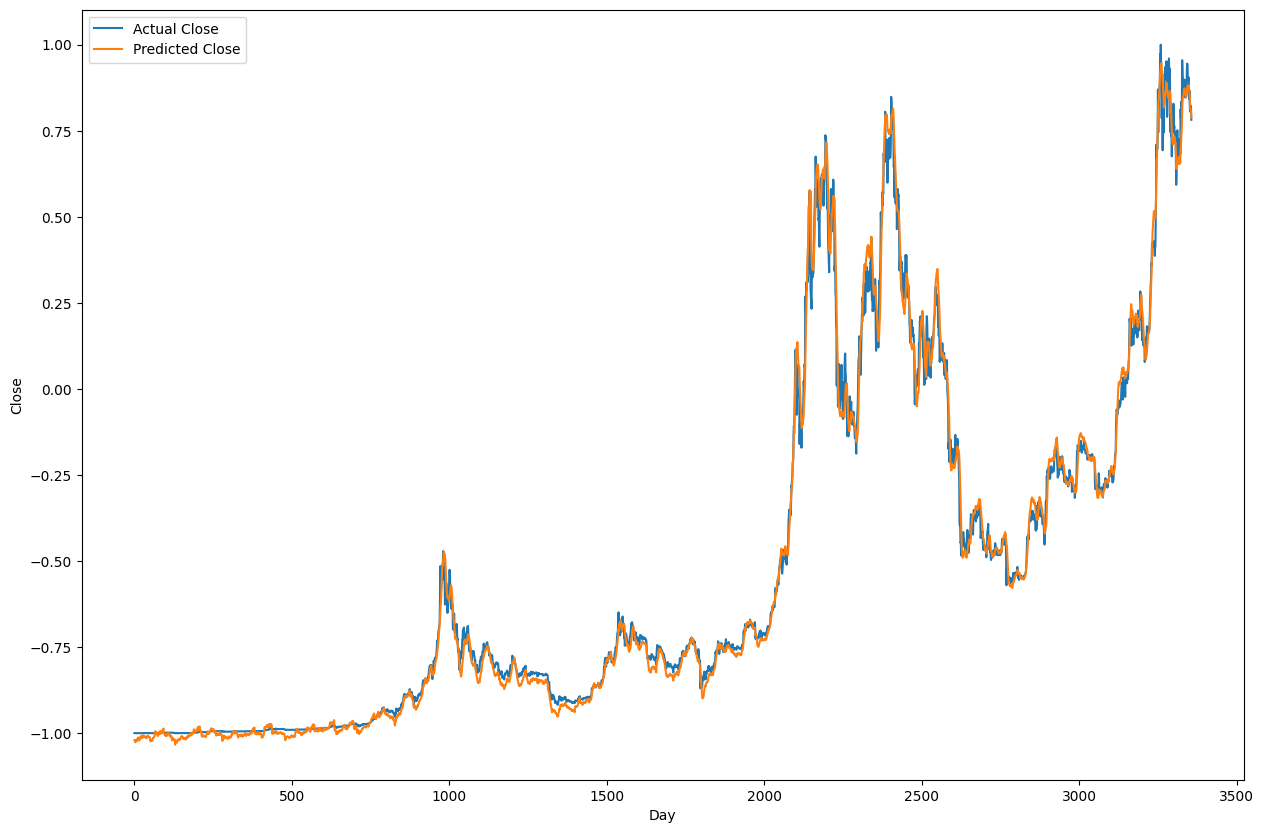

In [105]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()
    
plt.figure(figsize=(15, 10))
plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

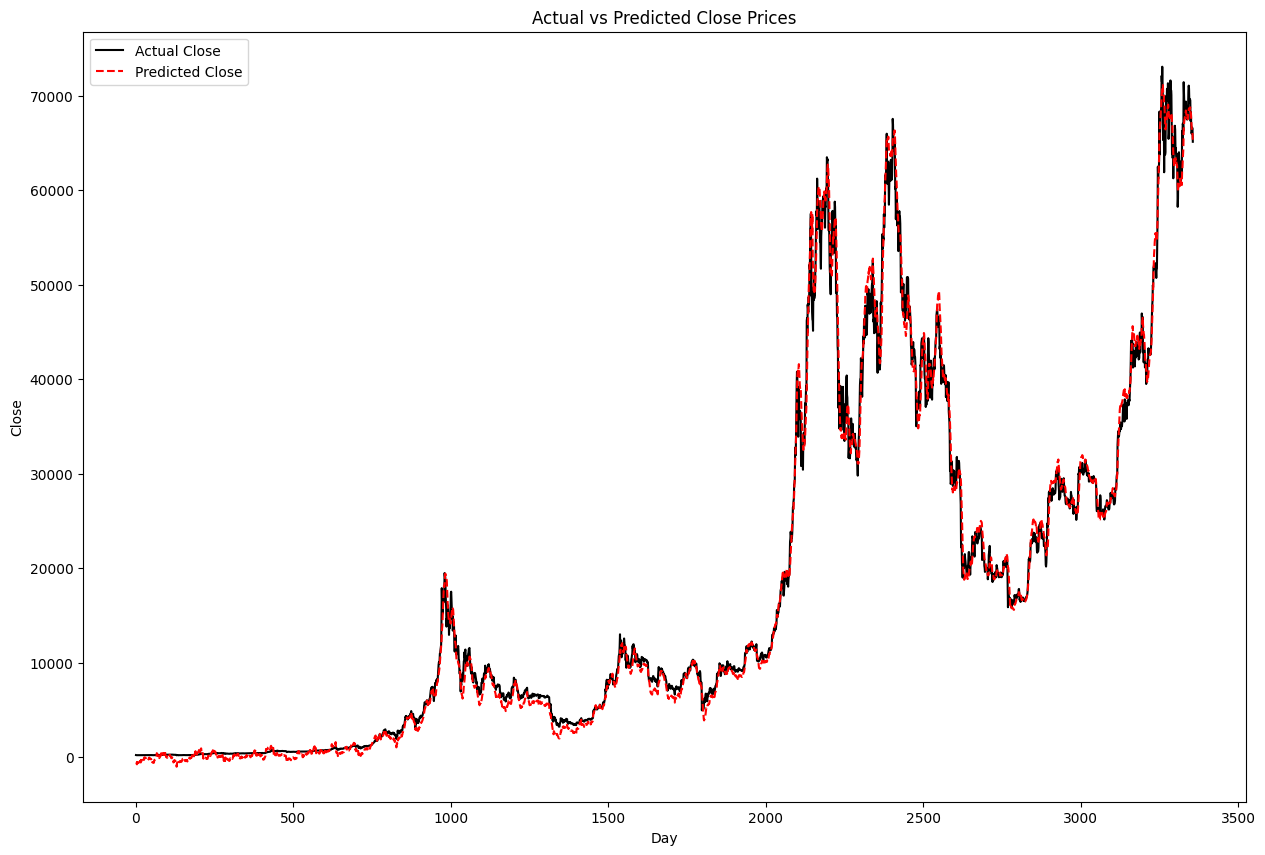

In [106]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], 15+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions
dummies = np.zeros((X_train.shape[0], 15+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

plt.figure(figsize=(15, 10))

plt.plot(new_y_train, label='Actual Close', color='black')
plt.plot(train_predictions, label='Predicted Close', color='red', linestyle='--')
plt.title('Actual vs Predicted Close Prices')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


### Predicciones

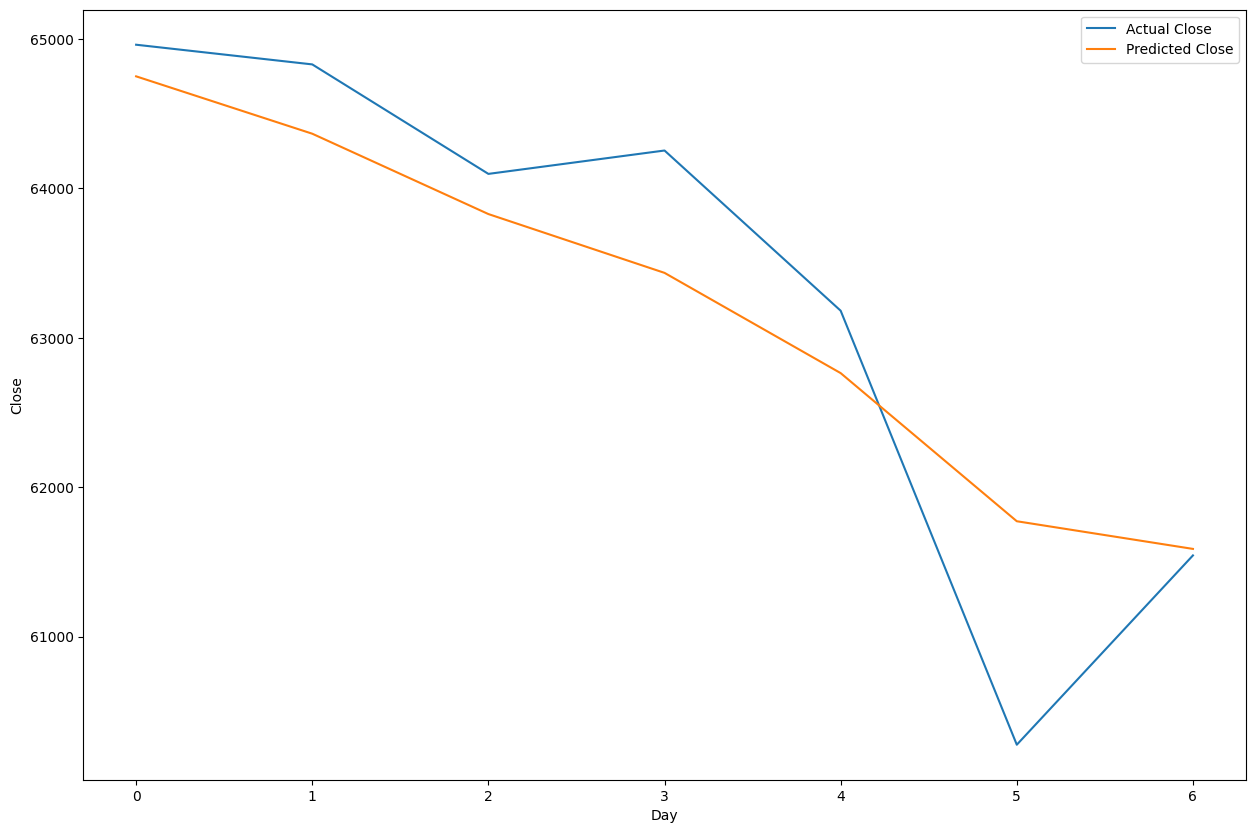

In [107]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], 15+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions
dummies = np.zeros((X_test.shape[0], 15+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

plt.figure(figsize=(15, 10))
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


Mean Squared Error (MSE): 487601.82960906235
Root Mean Squared Error (RMSE): 698.2849200785181
Mean Absolute Error (MAE): 531.2163874861393
R² Score: 0.8191103888726561


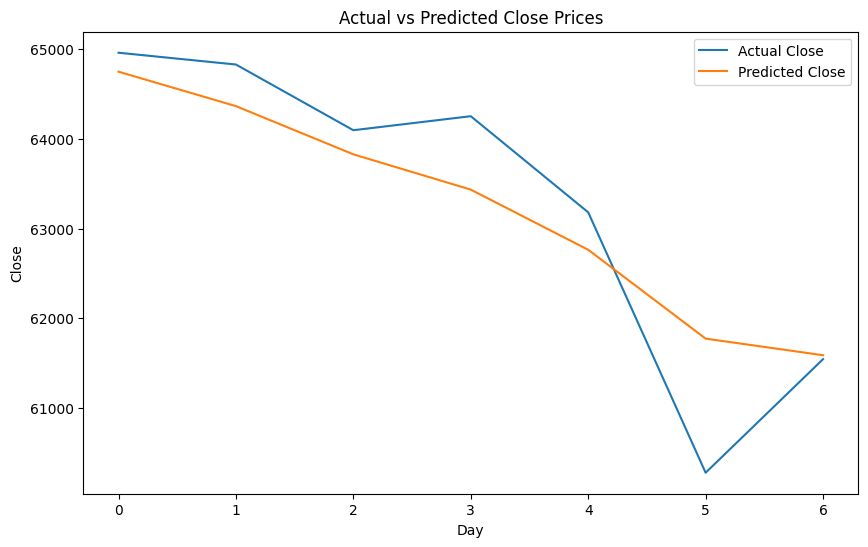

In [108]:
# Obtener las predicciones del modelo
model.eval()
with torch.no_grad():
    y_pred = []
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_pred_batch = model(X_batch)
        y_pred.append(y_pred_batch.cpu().numpy())

y_pred = np.concatenate(y_pred).flatten()

# Crear una matriz dummy con las dimensiones correctas
num_features = data_scaled.shape[1]  # Asegurarse de que coincida con las características originales
dummies_pred = np.zeros((len(y_pred), num_features))
dummies_test = np.zeros((len(y_test), num_features))

# Insertar las predicciones y los valores reales en la primera columna
dummies_pred[:, 0] = y_pred
dummies_test[:, 0] = y_test.cpu().numpy().flatten()

# Inversión de la escala de las predicciones
y_pred_inversed = scaler.inverse_transform(dummies_pred)[:, 0]

# Inversión de la escala de los valores reales
y_test_inversed = scaler.inverse_transform(dummies_test)[:, 0]

# Calcular las métricas de evaluación
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calcular las métricas de evaluación
mse = mean_squared_error(y_test_inversed, y_pred_inversed)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_inversed, y_pred_inversed)
r2 = r2_score(y_test_inversed, y_pred_inversed)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R² Score: {r2}')

# Visualizar los resultados
plt.figure(figsize=(10, 6))
plt.plot(y_test_inversed, label='Actual Close')
plt.plot(y_pred_inversed, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.title('Actual vs Predicted Close Prices')
plt.show()


In [109]:
# Obtener las predicciones del modelo
model.eval()
with torch.no_grad():
    y_pred = []
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_pred_batch = model(X_batch)
        y_pred.append(y_pred_batch.cpu().numpy())

y_pred = np.concatenate(y_pred).flatten()

# Crear una matriz dummy con las dimensiones correctas
# Aquí data_scaled.shape[1] debe ser el número de características originales
num_features = data_scaled.shape[1]
dummies_pred = np.zeros((len(y_pred), num_features))
dummies_test = np.zeros((len(y_test), num_features))

# Insertar las predicciones y los valores reales en la primera columna
dummies_pred[:, 0] = y_pred
dummies_test[:, 0] = y_test.cpu().numpy().flatten()

# Inversión de la escala de las predicciones
y_pred_inversed = scaler.inverse_transform(dummies_pred)[:, 0]

# Inversión de la escala de los valores reales
y_test_inversed = scaler.inverse_transform(dummies_test)[:, 0]


In [110]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test_inversed, y_pred_inversed)
mae = mean_absolute_error(y_test_inversed, y_pred_inversed)
r2 = r2_score(y_test_inversed, y_pred_inversed)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R² Score: {r2}')


Mean Squared Error (MSE): 487601.82960906235
Mean Absolute Error (MAE): 531.2163874861393
R² Score: 0.8191103888726561


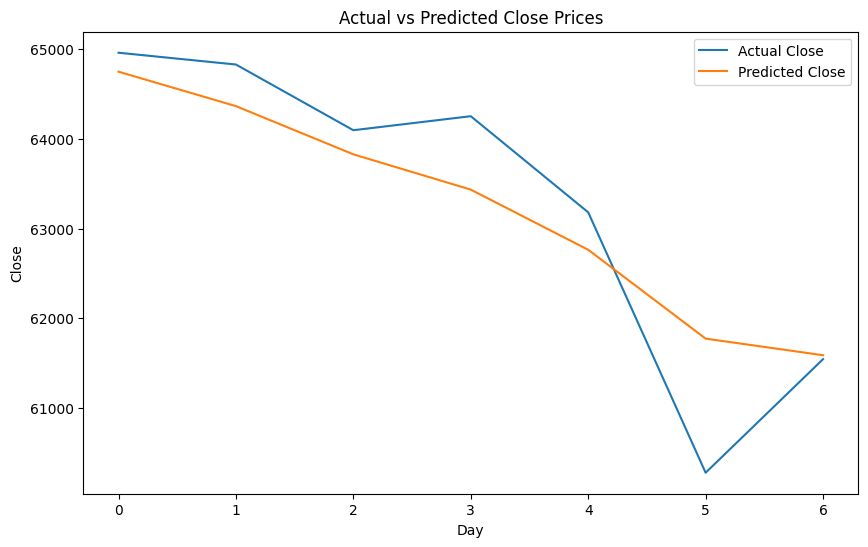

In [111]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_inversed, label='Actual Close')
plt.plot(y_pred_inversed, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.title('Actual vs Predicted Close Prices')
plt.show()


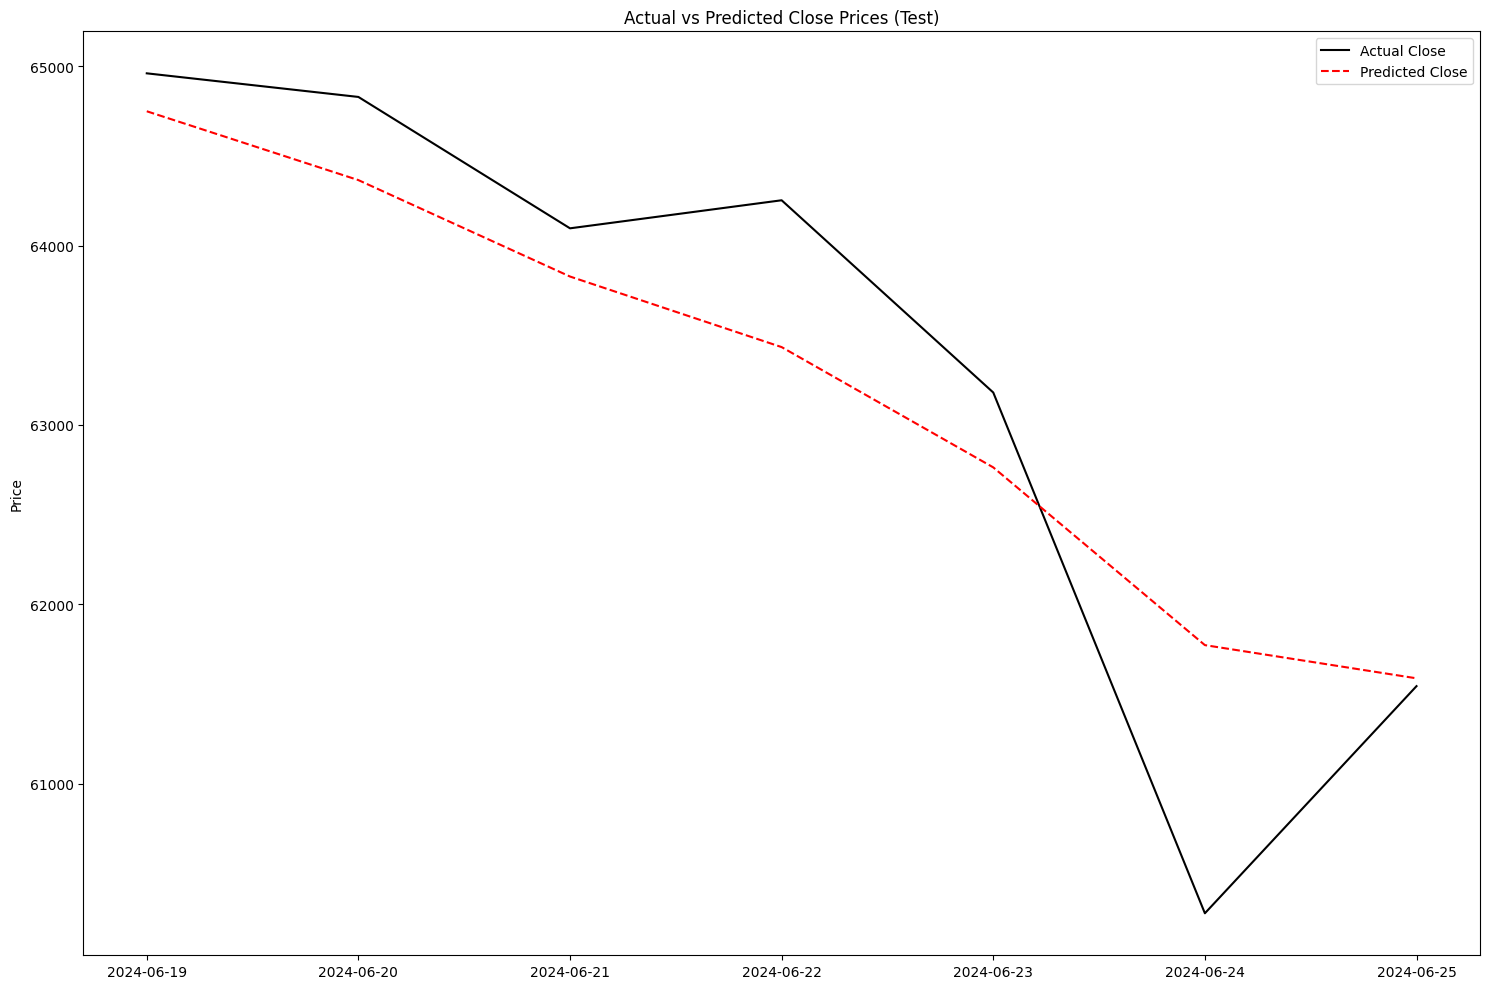

In [112]:
import matplotlib.pyplot as plt

# Supongamos que ya tienes `data` que incluye los indicadores técnicos y el índice adecuado.
# `y_test_inversed` y `y_pred_inversed` contienen los valores reales y predichos de los precios de cierre.

# Crear un DataFrame temporal para los datos predichos y reales
result_df = pd.DataFrame({
    'Actual Close': y_test_inversed,
    'Predicted Close': y_pred_inversed,
    'Date': data.index[-len(y_test_inversed):]
}).set_index('Date')

# Configurar el tamaño de la figura
plt.figure(figsize=(15, 10))

# Crear el subplot para precios reales y predichos
ax1 = plt.subplot(1, 1, 1)  # Para precios reales y predichos

# Gráfico de precios reales y predichos
ax1.plot(result_df.index, result_df['Actual Close'], label='Actual Close', color='black')
ax1.plot(result_df.index, result_df['Predicted Close'], label='Predicted Close', color='red', linestyle='--')
ax1.set_title('Actual vs Predicted Close Prices (Test)')
ax1.set_ylabel('Price')
ax1.legend()

# Ajustar el layout y mostrar los gráficos
plt.tight_layout()
plt.show()

